Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

After you finish the assignment and fill in your code and response where needed (all cells should have been run), save the notebook as a PDF using the `jupyter nbconvert --to pdf HW8.ipynb` command (via a notebook code cell or the command line directly) and submit the PDF to Gradescope under the PDF submission item. If you cannot get this to work locally, you can upload the notebook to Google Colab and create the PDF there. You can find the notebook containing the instruction for this on Canvas.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW8.ipynb`
- `generator_config.yaml`
- `discriminator_config.yaml`
- `train_config.yaml`

In [1]:
"""
DO NOT MODIFY THIS CELL OR ADD ANY ADDITIONAL IMPORTS ANYWHERE ELSE IN THIS NOTEBOOK!
"""
from typing import Sequence, Union
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.autolayout': True})
from IPython.display import display, clear_output

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/24789HW8")

from HW8_utils import AirfoilDataset

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'
print(f'Device is {Device}')

Mounted at /content/drive
Device is cpu


# Fundamentals of Generative Adversarial Networks (30)

First, you have to answer some questions to validate your knowledge about the fundamentals of GANs. Explain your reasoning for each question, and keep your response concise.

You can also verify your answers by what you observe in the programming section of the assignment.

## __QUESTION 1__ (10)

For a GAN with a well-balanced generator and discriminator, what should the output of the discriminator be for real data $D(x)$ and fake data $D\big(G(z)\big)$ in the early iterations of training? How should $D(x)$ and $D\big(G(z)\big)$ change as the training progresses? (For each case, should it be closer to 0 or 0.5 or 1?)

What would indicate getting close to a successfully trained GAN?

__RESPONSE__:

In the early stages of training, the generator has almost no fit, and the performance on fake data will be very poor. Therefore, the discriminator will easily identify false data, D(x) will be very close to 1, and D(G(z)) will be very close to 0.

As the training progresses, the generator gradually learns, and the generated data gradually approaches the training samples. Ideally, both D(x) and D(G(z)) will converge towards 0.5. If D(x) and D(G(z)) both stabilize at 0.5 at the end of the training, then the GAN training is perfect.

## __QUESTION 2__ (10)

Assume you have started training a GAN, and you observe in the early iterations that the generator and discriminator losses are similar. The output of the discriminator for real and fake data are also similar.

Do you think that the training will be successful and lead to a good GAN capable of generating realistic samples? If not, what is the problem and how could you mitigate it?

__RESPONSE__:

If the generator and discriminator losses are similar in early iterations, this means that the discriminator has not learned how to distinguish real data from fake data at all. This is a red flag that we may need a wider or deeper discriminator to capture the difference between real and fake data.

## __QUESTION 3__ (10)

Assume you have started training a GAN, and you observe that the discriminator loss quickly converges to zero, while the generator loss seems unstable or very large even after training for some time. What do you think the discriminator score is for real and fake data?

Do you think that the training will be successful and lead to a good GAN capable of generating realistic samples? If not, what is the problem and how could you mitigate it?

__RESPONSE__:

Converging the discriminator too quickly during training is also a bad sign. Because this will result in the generator being unable to fool the discriminator and not getting any effective gradient information feedback. Simplifying the discriminator architecture (reduce hidden size), reducing the discriminator learning rate, or using a coefficient of real target * 0.9 (target = torch.ones_like(D_real) * 0.9) are all approaches that can be tried.

# Implement and train a GAN to generate airfoils (70)

You are provided with the UIUC airfoil dataset consisting of 1547 airfoil profiles. The Dataset class to load the data is provided in `HW8_utils.py`. Let's take a look at the dataset. Each sample consists of the y-coordinates of points at pre-defined locations on the x-axis, as well as the name of the airfoil. You will not need the names.

In [2]:
airfoil_dataset = AirfoilDataset()
print(f'dataset has {len(airfoil_dataset)} samples')

dataset has 1547 samples


In [3]:
sample_idx = 431
y, name = airfoil_dataset[sample_idx]
print(f'y is {type(y)} and has shape {y.shape} and dtype {y.dtype}')

y is <class 'numpy.ndarray'> and has shape (200,) and dtype float32


## Implement a Generator and a Discriminator (20)

You do not need a complicated architecture for the generator and discriminator in this assignment. You can use the example from the recitation to implement the general architecture, but do not copy the exact models, since there might be details specific to the datasets. Try to implement the models by yourself to get comfortable with defining soft-coded atchutectures.

In [4]:
# AUTOGRADED

class Generator(nn.Module):

    def __init__(
            self,
            latent_size: int,
            output_size: int,
            hidden_dim: int = 512
            ):
        super().__init__()

        self.latent_size = latent_size

        self.net = nn.Sequential(
            nn.Linear(latent_size, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_size),
            nn.Tanh()
        )

    def forward(
            self,
            z: torch.FloatTensor, # (batch_size, latent_size)
            ) -> torch.FloatTensor: # (batch_size, *output_shape)
        """
        Input z is the latent vector, typically sampled from N(0, I)
        Outputs generated samples
        """
        return self.net(z)

    def generate(
            self,
            n_samples: int,
            device: str = Device,
            ) -> torch.FloatTensor: # (n_samples, output_size)
        """
        move self to the device
        sample n_samples latent vectors from N(0, I)
        generate n_samples samples
        """
        self.to(device)

        z = torch.randn(n_samples, self.latent_size, device=device)
        return self.forward(z)


class Discriminator(nn.Module):

    def __init__(
            self,
            input_size: int,
            hidden_dim: int = 512

            ):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(
            self,
            x: torch.FloatTensor, # (batch_size, input_size)
            ) -> torch.FloatTensor: # (batch_size, 1)

        return self.net(x)

## Tracking and Visualization

In [5]:
class GAN_Tracker:
    """
    Logs and plots different loss terms of a GAN during training.
    """
    def __init__(
            self,
            n_iters: int,
            plot_freq: Union[int, None] = None, # plot every plot_freq iterations
            ):

        self.real_scores = []
        self.fake_scores = []
        self.D_losses = []
        self.G_losses = []

        self.plot = plot_freq is not None
        self.iter = 0
        self.n_iters = n_iters

        if self.plot:
            self.plot_freq = plot_freq
            self.plot_results()


    def plot_results(self):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(13, 3), sharex=True)

        # Score plot:
        self.real_score_curve, = self.ax1.plot(
            range(1, self.iter+1),
            self.real_scores,
			label = r'$D(x)$',
            )
        self.fake_score_curve, = self.ax1.plot(
            range(1, self.iter+1),
            self.fake_scores,
            label = r'$D(G(z))$',
            )

        self.ax1.set_xlim(0, self.n_iters+1)
        self.ax1.set_ylim(0, 1)
        self.ax1.set_xlabel('Iteration')
        self.ax1.set_ylabel('Discriminator Score')
        self.ax1.set_title('Discriminator Score')
        self.ax1.grid(linestyle='--')
        self.ax1.legend()

        # Loss plot:
        self.D_loss_curve, = self.ax2.plot(
            range(1, self.iter+1),
            self.D_losses,
			label = 'D',
            )
        self.G_loss_curve, = self.ax2.plot(
            range(1, self.iter+1),
            self.G_losses,
            label = 'G',
            )
        self.ax2.set_xlim(0, self.n_iters+1)
        self.ax2.set_xlabel('Iteration')
        self.ax2.set_ylabel('Loss')
        self.ax2.set_title('Learning Curve')
        self.ax2.grid(linestyle='--')
        self.ax2.legend()

        self.samples_fig, self.samples_axes = plt.subplots(4, 6, figsize=(12, 8), sharex=True, sharey=True)
        self.sample_axes = self.samples_axes.flat
        self.samples = []
        for ax in self.sample_axes:
            self.samples.append(ax.plot(airfoil_dataset.get_x(), np.zeros_like(airfoil_dataset.get_x()))[0])
            ax.set_xlim(-0.1, 1.1)
            ax.set_ylim(-0.6, 0.6)
            ax.set_aspect('equal')
            ax.grid(linestyle='--')


    def update(
            self,
            real_score: float,
            fake_score: float,
            D_loss: float,
            G_loss: float,
            ):
        self.real_scores.append(real_score)
        self.fake_scores.append(fake_score)
        self.D_losses.append(D_loss)
        self.G_losses.append(G_loss)
        self.iter += 1

        if self.plot and self.iter % self.plot_freq == 0:

            # score plot:
            self.real_score_curve.set_data(range(1, self.iter+1), self.real_scores)
            self.fake_score_curve.set_data(range(1, self.iter+1), self.fake_scores)
            self.ax1.relim()
            self.ax1.autoscale_view()

            # loss plot:
            self.D_loss_curve.set_data(range(1, self.iter+1), self.D_losses)
            self.G_loss_curve.set_data(range(1, self.iter+1), self.G_losses)
            self.ax2.relim()
            self.ax2.autoscale_view()

            self.samples_fig.suptitle(f'Generated Samples at Iteration {self.iter}')

            self.fig.canvas.draw()
            clear_output(wait=True)
            display(self.fig)
            display(self.samples_fig)


    def get_samples(
            self,
            samples: torch.FloatTensor, # (n_samples, *output_shape)
            ):
        for sample, sample_img in zip(samples, self.samples):
            sample_img.set_ydata(sample.detach().cpu().numpy())


## Losses (15)

Hint: use `F.binary_cross_entropy` with the right input and target.

In [6]:
def D_real_loss_fn(
        D_real: torch.FloatTensor, # (batch_size, 1)
        ) -> torch.FloatTensor: # ()
    """
    D_real is D(x), the discriminator's output when fed with real images
    We want this to be close to 1, because the discriminator should recognize real images
    """
    target = torch.ones_like(D_real)
    return F.binary_cross_entropy(D_real, target)

def D_fake_loss_fn(
        D_fake: torch.FloatTensor, # (batch_size, 1)
        ) -> torch.FloatTensor: # ()
    """
    D_fake is D(G(z)), the discriminator's output when fed with generated images
    We want this to be close to 0, because the discriminator should not be fooled
    """
    target = torch.zeros_like(D_fake)
    return F.binary_cross_entropy(D_fake, target)

def G_loss_fn(
        D_fake: torch.FloatTensor, # (batch_size, 1)
        ) -> torch.FloatTensor: # ()
    """
    D_fake is D(G(z)), the discriminator's output when fed with generated images
    We want this to be close to 1, because the generator wants to fool the discriminator
    """
    target = torch.ones_like(D_fake)
    return F.binary_cross_entropy(D_fake, target)

## Training (15)

We suggest you avoid copy-pasting from the recitation and try to remember the steps in training a GAN to learn it well. After you implement your solution, compare with the recitation and correct your code accordingly.

In [7]:
def train_GAN(
        generator: Generator,
        discriminator: Discriminator,
        train_dataset: Dataset,
        device: str = Device,
        plot_freq: int = 100,

        # Generator
        optimizer_name_G: str = 'Adam',
        optimizer_config_G: dict = dict(lr=1e-3),
        lr_scheduler_name_G: Union[str, None] = None,
        lr_scheduler_config_G: dict = dict(),

        # Discriminator
        optimizer_name_D: str = 'Adam',
        optimizer_config_D: dict = dict(lr=1e-3),
        lr_scheduler_name_D: Union[str, None] = None,
        lr_scheduler_config_D: dict = dict(),

        n_iters: int = 10000,
        batch_size: int = 64,
        ):

    generator = generator.to(device)
    discriminator = discriminator.to(device)

    optimizer_G: optim.Optimizer = optim.__getattribute__(optimizer_name_G)(generator.parameters(), **optimizer_config_G)
    if lr_scheduler_name_G is not None:
        lr_scheduler_G: lr_scheduler._LRScheduler = lr_scheduler.__getattribute__(lr_scheduler_name_G)(optimizer_G, **lr_scheduler_config_G)

    optimizer_D: optim.Optimizer = optim.__getattribute__(optimizer_name_D)(discriminator.parameters(), **optimizer_config_D)
    if lr_scheduler_name_D is not None:
        lr_scheduler_D: lr_scheduler._LRScheduler = lr_scheduler.__getattribute__(lr_scheduler_name_D)(optimizer_D, **lr_scheduler_config_D)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    tracker = GAN_Tracker(n_iters=n_iters, plot_freq=plot_freq)

    iter_pbar = tqdm(range(n_iters), desc='Training', unit='iter')
    iter = 0

    while iter < n_iters:

        for x_real, _ in train_loader:

            x_real = x_real.to(device)
            n_samples = len(x_real)

            # ============ Train Discriminator ============

            optimizer_D.zero_grad()

            D_real = discriminator(x_real)
            loss_D_real = D_real_loss_fn(D_real)

            z = torch.randn(n_samples, generator.latent_size, device=device)
            x_fake = generator(z).detach()
            D_fake = discriminator(x_fake)
            loss_D_fake = D_fake_loss_fn(D_fake)

            loss_D = loss_D_real + loss_D_fake
            loss_D.backward()
            optimizer_D.step()

            D_real_avg: float = D_real.mean().item() # average output of discriminator on real data, for logging
            D_fake_avg: float = D_fake.mean().item() # average output of discriminator on fake data, for logging
            D_loss_item: float = loss_D.item() # For logging

            # ============ Train Generator ============

            optimizer_G.zero_grad()

            z = torch.randn(n_samples, generator.latent_size, device=device)
            x_fake = generator(z)
            D_fake_for_G = discriminator(x_fake)
            loss_G = G_loss_fn(D_fake_for_G)
            loss_G.backward()
            optimizer_G.step()

            if lr_scheduler_name_G is not None:
                lr_scheduler_G.step()

            G_loss_item: float = loss_G.item() # For logging

            # ============ Logging =================
            iter += 1
            iter_pbar.update(1)
            if iter % plot_freq == 0:
                with torch.inference_mode():
                    tracker.get_samples(generator.generate(n_samples=24, device=device))
            tracker.update(D_real_avg, D_fake_avg, D_loss_item, G_loss_item)

            if iter >= n_iters:
                break

## Find and train a good model (20)

As usual, find a good set of hyperparameters and train your model. However, you have to evaluate your model qualitatively by looking at some generated samples. A nice airfoil would be an airfoil with a smooth surface. For this dataset, making a GAN work is more tricky than what you experienced with a VAE, so the generated samples may not be as smooth. In the figure below, all samples are considered nice enough except one.

Your grade also depends on the diversity of the generated samples. If all your samples look the same, your GAN is suffering from _mode collapse_, and you will get at most 5 points depending on the quality of the sample. If your samples are diverse but not nice, you will get 0 (garbage), 5 (too bad, but looks like airfoils), 10 (not bad), or 15 (almost there) points depending on how nice they are. The grading will be generously done.


__HINT__: Think about how to balance the generator and discriminator and stabilize the training as it progresses. You may find using learning rate schedulers useful.

__DO NOT CHANGE__ `input_size` and `latent_size`.

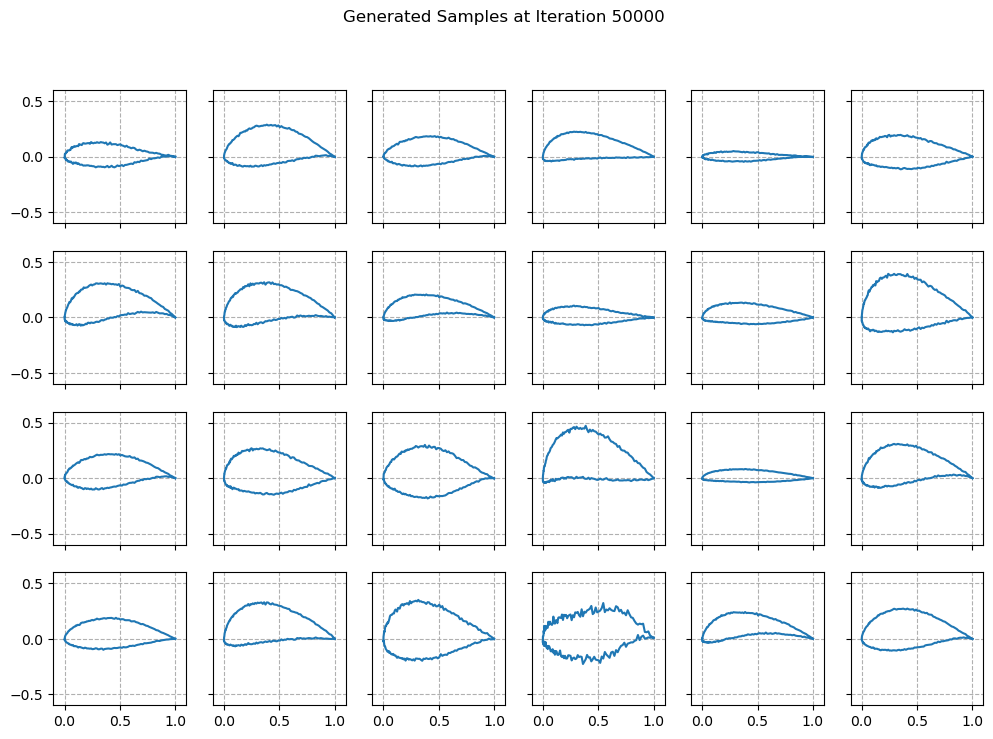

In [26]:
"""
Choose model and training configuration
"""
input_size = 200 # DO NOT CHANGE
latent_size = 16 # DO NOT CHANGE

generator_config = dict(
    latent_size = latent_size,
    output_size = input_size,
    hidden_dim=512,
    )

discriminator_config = dict(
    input_size = input_size,
    hidden_dim=512,
    )

train_config = dict(
    # Generator
    optimizer_name_G = 'Adam',
    optimizer_config_G = {'lr': 2.5e-5, 'betas': (0.5, 0.999)},
    lr_scheduler_name_G = None,
    lr_scheduler_config_G = dict(),

    # Discriminator
    optimizer_name_D = 'Adam',
    optimizer_config_D = {'lr': 2.25e-5, 'betas': (0.5, 0.999)},
    lr_scheduler_name_D = None,
    lr_scheduler_config_D = dict(),

    n_iters = 20000,
    batch_size = 256,
    )

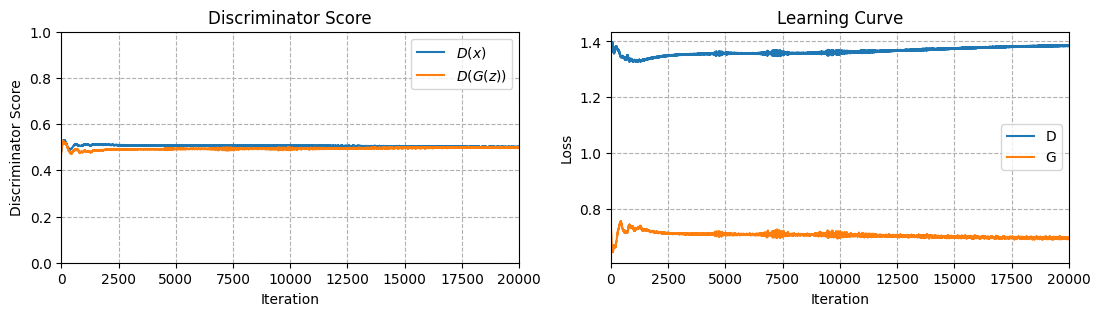

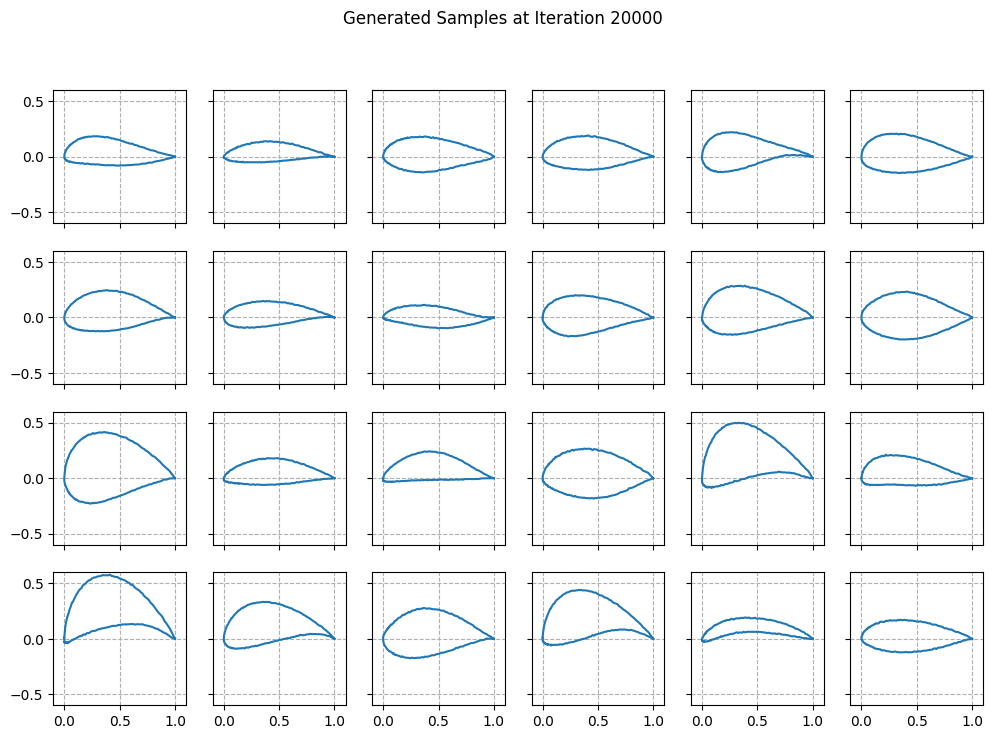

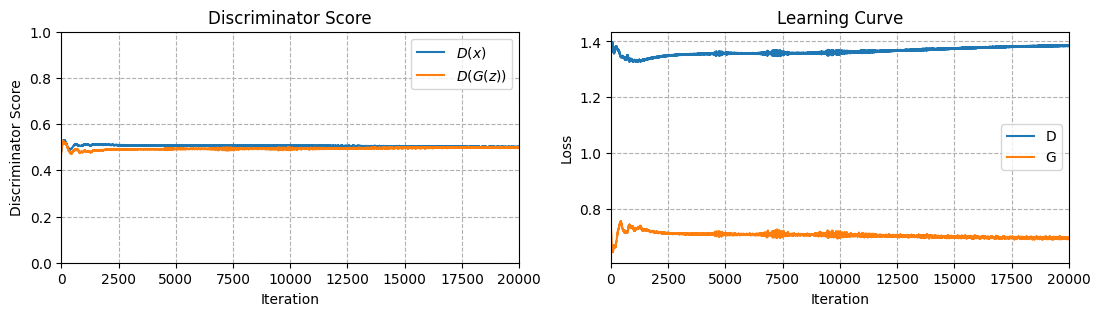

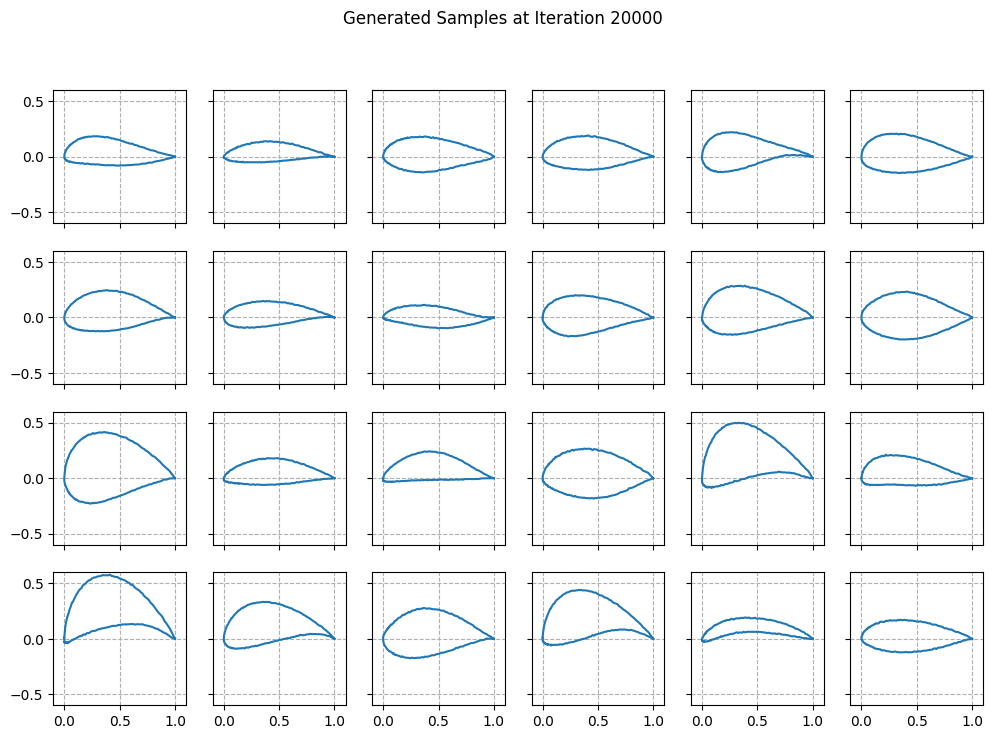

In [27]:
if __name__ == '__main__':
    generator = Generator(**generator_config)
    discriminator = Discriminator(**discriminator_config)
    train_GAN(
        generator = generator,
        discriminator = discriminator,
        train_dataset = airfoil_dataset,
        device = Device,
        plot_freq = 1000,
        **train_config,
        )

# Zip files for submission

In [22]:
from HW8_uti8ls import save_yaml, zip_files

save_yaml(generator_config, 'generator_config.yaml')
save_yaml(discriminator_config, 'discriminator_config.yaml')
save_yaml(train_config, 'train_config.yaml')

submission_files = ['HW8.ipynb', 'generator_config.yaml', 'discriminator_config.yaml', 'train_config.yaml']
zip_files('HW8_submission.zip', submission_files)

In [23]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-fre

In [25]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/24789HW8/HW8.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/24789HW8/HW8.ipynb to pdf
[NbConvertApp] Support files will be in HW8_files/
[NbConvertApp] Making directory ./HW8_files
[NbConvertApp] Writing 102394 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 378302 bytes to /content/drive/MyDrive/24789HW8/HW8.pdf
